In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_roc, plot_ks_statistic, plot_lift_curve, plot_cumulative_gain, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import mean_squared_error

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score



import plotly.graph_objects as go

from plotly.subplots import make_subplots


## Assess

In [2]:
file_path_1 = '/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/X_train_M.csv'
train_t = pd.read_csv(file_path_1)

file_path_2 ='/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/X_val_M.csv'
val_t = pd.read_csv(file_path_2)

file_path_3 = '/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/X_test_M.csv'
test_t = pd.read_csv(file_path_3)

In [3]:
file_path_4 = '/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/y_train.csv'
y_train = pd.read_csv(file_path_4)
y_train = y_train.iloc[:,0]

file_path_5 = '/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/y_val.csv'
y_val = pd.read_csv(file_path_5)
y_val = y_val.iloc[:,0]

file_path_6 = '/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/y_test.csv'
y_test = pd.read_csv(file_path_6)
y_test = y_test.iloc[:,0]

In [4]:
class ModelAnalyzer:


    def __init__(self, hiperparametros, X_train, y_train, X_val, y_val):
        self.y_train = y_train
        self.y_val = y_val

        self.X_train = X_train
        self.X_val = X_val

        self.modelo = LogisticRegression(**hiperparametros)
        self.modelo.fit(X_train, y_train)
        

        self.importance_reg = pd.DataFrame(data= {'Coeficientes':self.modelo.coef_[0],
                                                  'Abs_Coeficientes':abs(self.modelo.coef_[0])},
                                           index=X_train.columns).sort_values(by='Abs_Coeficientes', ascending=False)


        self.y_predito_train = self.modelo.predict(X_train)
        self.y_predito_val = self.modelo.predict(X_val)
        
        
        self.y_predito_proba_train = self.modelo.predict_proba(X_train)
        self.y_predito_proba_val = self.modelo.predict_proba(X_val)
        

        self.y_predito_log_proba_train = self.modelo.predict_log_proba(X_train)
        self.y_predito_log_proba_val = self.modelo.predict_log_proba(X_val)


    def tab_dist_client_classe(self, train=True):
        from feature_engine.discretisation import ArbitraryDiscretiser

        
        if train == True:
              X = self.X_train
              y_predito_proba = self.y_predito_proba_train
              y = self.y_train
        else:
              X = self.X_val
              y_predito_proba = self.y_predito_proba_val
              y = self.y_val
              
        df_temp = pd.DataFrame(index=X.index)
        df_temp['prob_good'] = y_predito_proba[:,0]
        df_temp['real'] = y
        df_temp = df_temp.sort_values(by='prob_good')
        
        #-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

        user_dict = {'prob_good': np.arange(0, 1.1, 0.1).tolist()}

        transformer = ArbitraryDiscretiser(binning_dict = user_dict, 
                                           return_object = False, 
                                           return_boundaries = False)

        df_temp_agg = transformer.fit_transform(df_temp)
        df_temp['SCR'] = df_temp_agg['prob_good']
        df_temp = df_temp.drop(axis=1, labels='prob_good')


        maus_percentual = df_temp.groupby('SCR')['real'].apply(lambda x: (x == 1).mean())
        bons_percentual = df_temp.groupby('SCR')['real'].apply(lambda x: (x == 0).mean())
        
        bm_ratio = bons_percentual / maus_percentual
        total = bons_percentual + maus_percentual

        novo_df = pd.DataFrame({'SCR': df_temp['SCR'].unique(),
                                'Maus': maus_percentual.values,
                                'Bons': bons_percentual.values,
                                'B/M': bm_ratio.values,
                                'Total': total.values
                                })

        # Ordenar o novo DataFrame pelo valor de 'SCR'
        novo_df = novo_df.sort_values(by='SCR')

        return novo_df


    def plot_estabilidade(self, train = True):
        # Extrai as colunas 'SCR', 'Maus', 'Bons' e 'B/M'
        novo_df = self.tab_dist_client_classe(train = train)
        scr = novo_df['SCR']
        maus = novo_df['Maus']
        bons = novo_df['Bons']
        bm = novo_df['B/M']

        def formatar_valor(valor):
            return f'{valor*100:.2f}%' 

        # Cria subplots com dois eixos verticais
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.update_layout(title='Proporção de Maus, Bons e B/M por SCR')

        # Adiciona as barras para 'Maus' e 'Bons' sobrepostas
        fig.add_trace(go.Bar(x=scr, y=maus, text=[formatar_valor(valor) for valor in maus], textposition='outside', name='Maus'), secondary_y=False)
        fig.add_trace(go.Bar(x=scr, y=bons, text=[formatar_valor(valor) for valor in bons], textposition='outside', name='Bons'), secondary_y=False)

        # Adiciona um gráfico de linhas para 'B/M'
        fig.add_trace(go.Scatter(x=scr, y=bm, mode='lines', name='B/M', line=dict(width=5,  color='black')), secondary_y=True)



        # Atualiza o layout do gráfico
        fig.update_layout(xaxis=dict(title='SCR', tickmode='array', tickvals=scr, ticktext=[str(val) for val in scr]),
                        yaxis=dict(title='Proporção', range=[0, 1]),
                        yaxis2=dict(title='B/M', overlaying='y', side='right', range=[0, max(bm)]),
                        barmode='group')

        # Exibe o gráfico
        fig.show()


    def predito_log_proba(self, train=True):
        if train == True:
            value = self.y_predito_log_proba_train
            
        else:
            value = self.y_predito_log_proba_val
        
        return value


    def predito_proba(self, train=True):
        if train == True:
            value = self.y_predito_proba_train
            
        else:
            value = self.y_predito_proba_val
        
        return value
    

    def predito(self, train=True):
        if train == True:
            value = self.y_predito_train
            
        else:
            value = self.y_predito_val
        
        return value


    def formula_scoragem(self):
        
        return self.importance_reg   


    def display_coef_plot(self):
        plt.figure(figsize=(20, 15))
        sns.barplot(x=self.importance_reg.index, y='Abs_Coeficientes', data=self.importance_reg)

        plt.xticks(rotation=90, fontsize=12)

        plt.xlabel('Variável')
        plt.ylabel('Coeficiente')
        plt.title('Importância das Variáveis', fontsize=30)

        plt.tight_layout()
        plt.show()


    def display_metrics(self):
        rmse_train = mean_squared_error(self.y_train, self.y_predito_proba_train[:,1], squared=False)
        print(f'Root Mean Squared Error Train: {rmse_train}')
        rmse_val = mean_squared_error(self.y_val, self.y_predito_proba_val[:,1], squared=False)
        print(f'Root Mean Squared Error Val: {rmse_val}')
    

    def display_roc(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        

        plot_roc(self.y_train, self.y_predito_proba_train, plot_micro=False, plot_macro=False, ax=axes[0], title='Treino')
        plot_roc(self.y_val, self.y_predito_proba_val, plot_micro=False, plot_macro=False, ax=axes[1], title='Validação')

        
        plt.show()
    
    
    def display_ks(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        plot_ks_statistic(self.y_train, self.y_predito_proba_train, ax=axes[0], title='KS de Treino')
        plot_ks_statistic(self.y_val, self.y_predito_proba_val, ax=axes[1], title='KS de Validação')
        
        plt.show()
    

    def display_lift(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        plot_lift_curve(self.y_train, self.y_predito_proba_train, ax=axes[0], title='Lift de Treino')
        plot_lift_curve(self.y_val, self.y_predito_proba_val, ax=axes[1], title='Lift de Validação')

        plt.show()
    
    
    def display_cumulative_gain(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        plot_cumulative_gain(self.y_train, self.y_predito_proba_train, ax=axes[0], title='CAP de Treino')
        plot_cumulative_gain(self.y_val, self.y_predito_proba_val, ax=axes[1], title='CAP de Validação')
        
        plt.show()


    def display_confusion_matrix(self):
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
            
            plot_confusion_matrix(self.y_train, self.y_predito_train, ax=axes[0], title='CAP de Treino',)
            plot_confusion_matrix(self.y_val, self.y_predito_val, ax=axes[1], title='CAP de Validação',)
            
            plt.show()

In [5]:
def class_weight_maker(y, classes):

  # Calcula a frequência das classs
  class_0_count = np.sum(y == 0)
  class_1_count = np.sum(y == 1)

  # Calcula o número total observações
  total_samples = len(y)

  # Calculate class weights using "balanced" mode
  class_weights = compute_class_weight('balanced', classes=classes, y=y)
  class_weight = {0: class_weights[0], 1: class_weights[1]}
  return class_weight

weight = class_weight_maker(y_train, [0, 1])



hiperparametros = {'penalty':'l1',
                   'tol':0.0001,
                   'C':0.42813323987193935,
                   'solver': 'liblinear',
                   'random_state':59,
                   'max_iter':10000,
                   'class_weight':weight}

**Modelo 1**

In [6]:
analyzer_1 = ModelAnalyzer(hiperparametros, train_t, y_train, val_t, y_val)

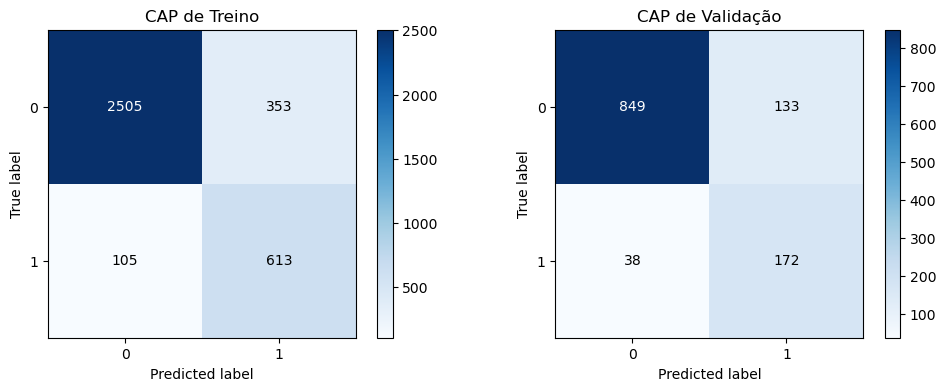

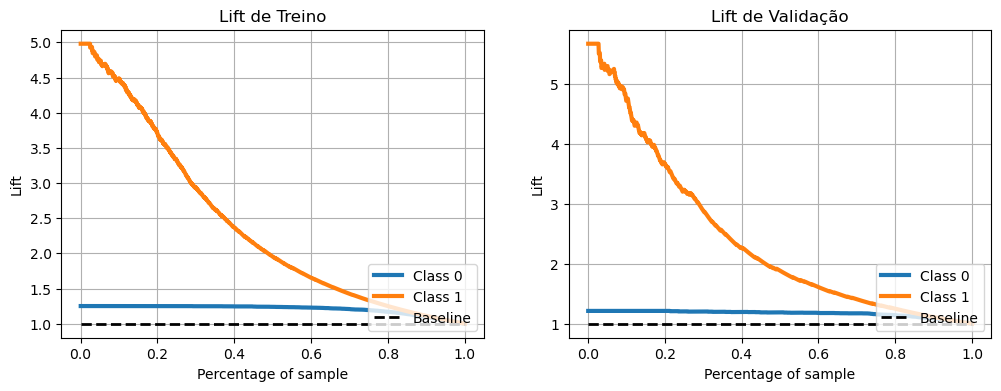

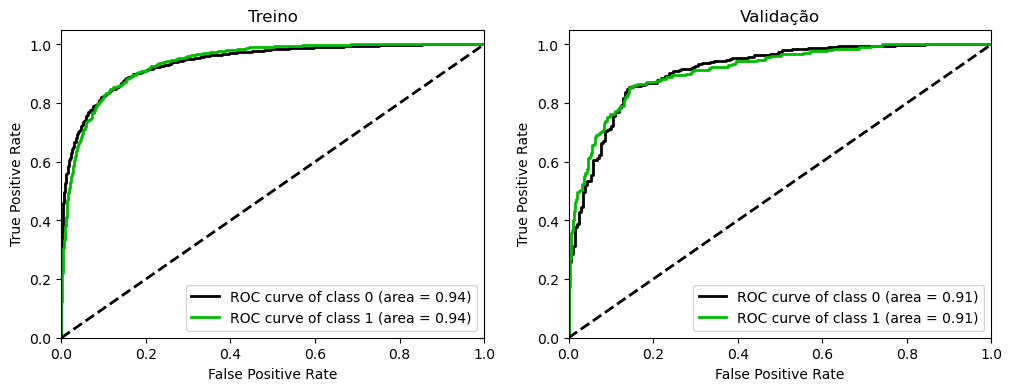

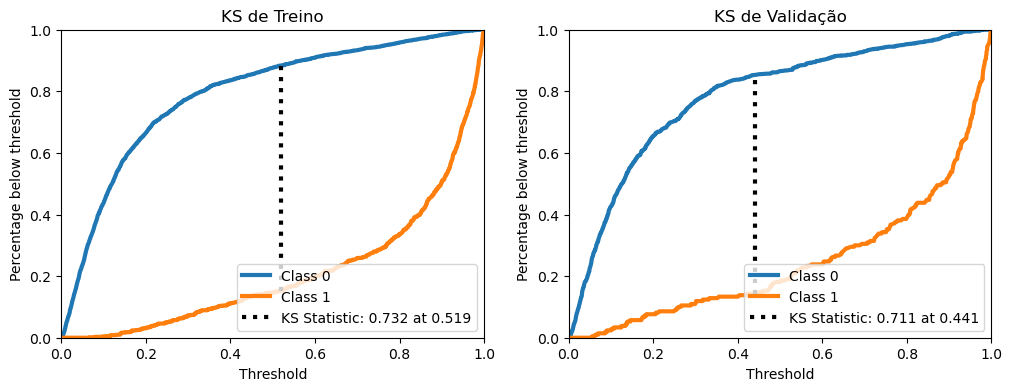

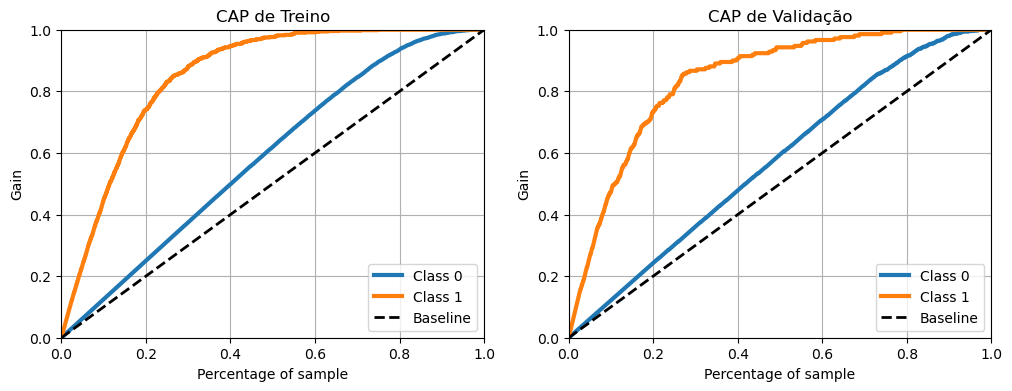

In [7]:
analyzer_1.display_confusion_matrix()
analyzer_1.display_lift()
analyzer_1.display_roc()
analyzer_1.display_ks()
analyzer_1.display_cumulative_gain()
plt.show()

In [8]:
display(analyzer_1.tab_dist_client_classe(train=False))

analyzer_1.plot_estabilidade(train = False)

,SCR,Maus,Bons,B/M,Total
0,0,0.833333,0.166667,0.200000,1.0
1,1,0.527273,0.472727,0.896552,1.0
2,2,0.425000,0.575000,1.352941,1.0
3,3,0.333333,0.666667,2.000000,1.0
4,4,0.250000,0.750000,3.000000,1.0
5,5,0.270270,0.729730,2.700000,1.0
6,6,0.070423,0.929577,13.200000,1.0
7,7,0.058333,0.941667,16.142857,1.0
8,8,0.046809,0.953191,20.363636,1.0
9,9,0.011792,0.988208,83.800000,1.0


**Modelo 2**

In [9]:
# Cria uma lista com as variáveis as variáveis com coef menor 0.5
feat_drop = analyzer_1.formula_scoragem()[analyzer_1.formula_scoragem()['Abs_Coeficientes'] <= 0.5].index.tolist()

# Remove as variáveis menos significativas das amostras
train_t_2 = train_t.drop(axis=1, labels=feat_drop)
val_t_2 = val_t.drop(axis=1, labels=feat_drop)

# Cria um novo modelo com a nova seleção de variáveis
analyzer_2 = ModelAnalyzer(hiperparametros, train_t_2, y_train, val_t_2, y_val)

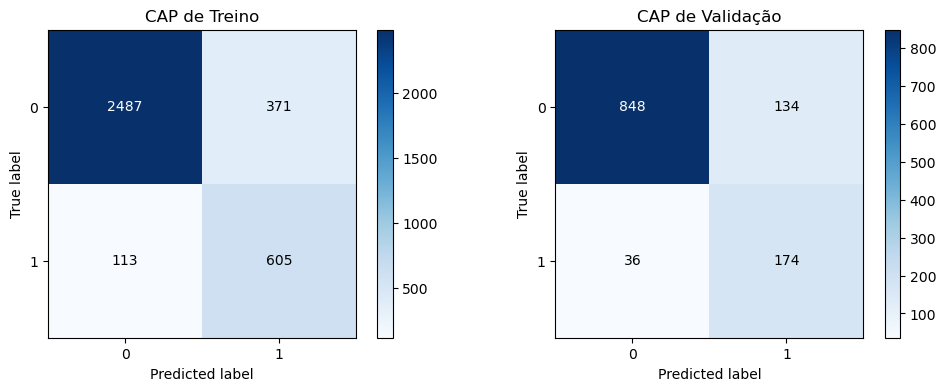

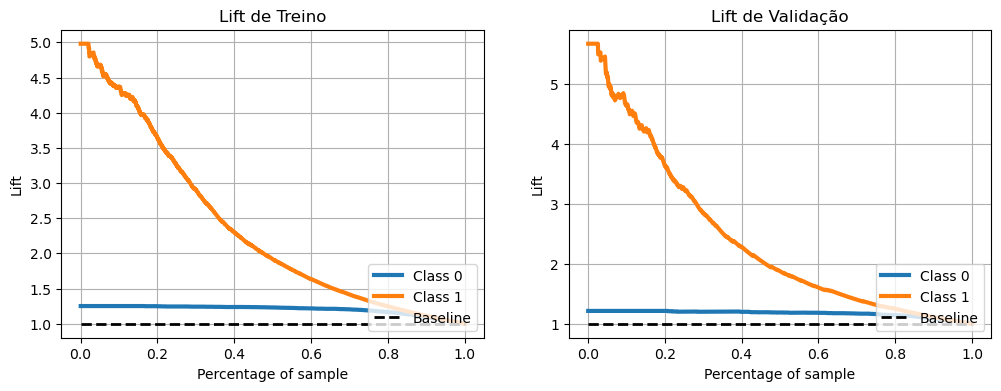

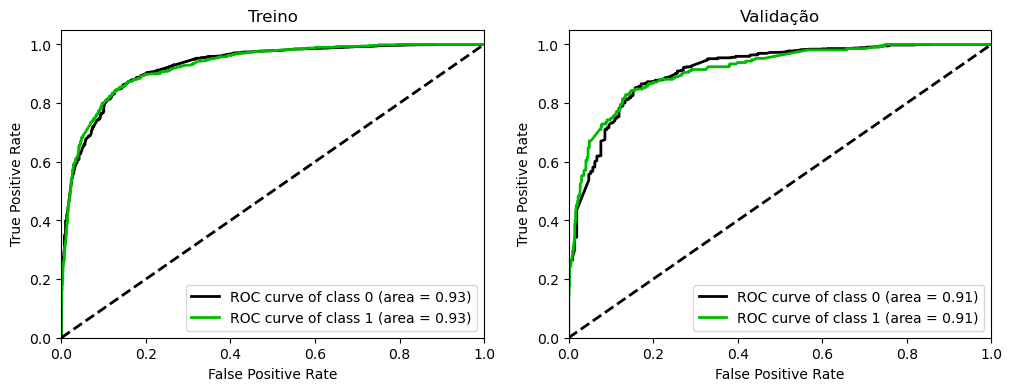

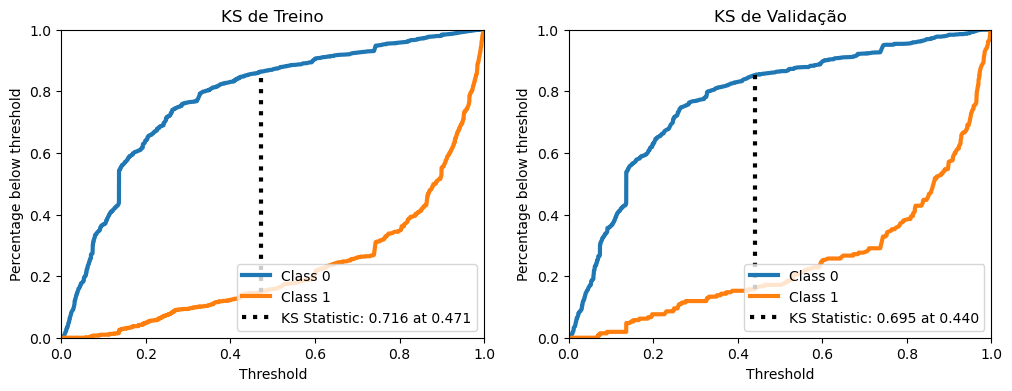

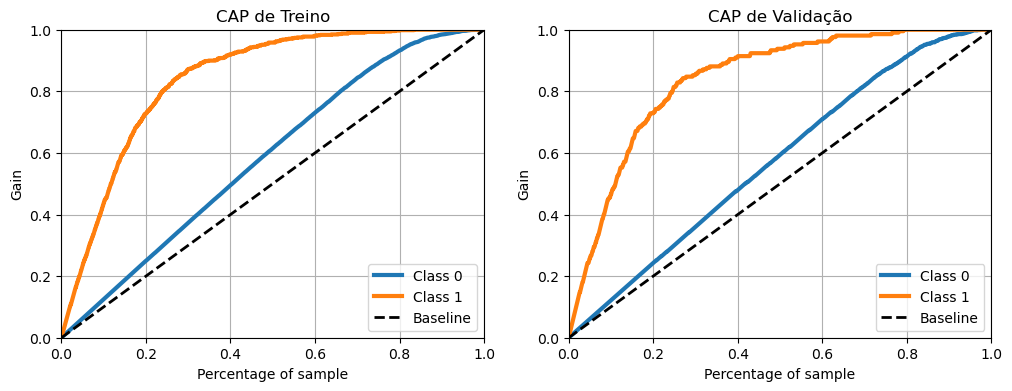

In [10]:
analyzer_2.display_confusion_matrix()
analyzer_2.display_lift()
analyzer_2.display_roc()
analyzer_2.display_ks()
analyzer_2.display_cumulative_gain()
plt.show()

In [11]:
display(analyzer_2.tab_dist_client_classe(train=False))

analyzer_2.plot_estabilidade(train = False)

,SCR,Maus,Bons,B/M,Total
0,0,0.849057,0.150943,0.177778,1.0
1,1,0.579710,0.420290,0.725000,1.0
2,2,0.415094,0.584906,1.409091,1.0
3,3,0.187500,0.812500,4.333333,1.0
4,4,0.333333,0.666667,2.000000,1.0
5,5,0.108108,0.891892,8.250000,1.0
6,6,0.102941,0.897059,8.714286,1.0
7,7,0.062937,0.937063,14.888889,1.0
8,8,0.043478,0.956522,22.000000,1.0
9,9,0.011111,0.988889,89.000000,1.0


**Modelo 3**

In [12]:
feat_drop = analyzer_1.formula_scoragem()[analyzer_1.formula_scoragem()['Abs_Coeficientes'] <= 0.3].index.tolist()

train_t_3 = train_t.drop(axis=1, labels=feat_drop)
val_t_3 = val_t.drop(axis=1, labels=feat_drop)

analyzer_3 = ModelAnalyzer(hiperparametros, train_t_3, y_train, val_t_3, y_val)

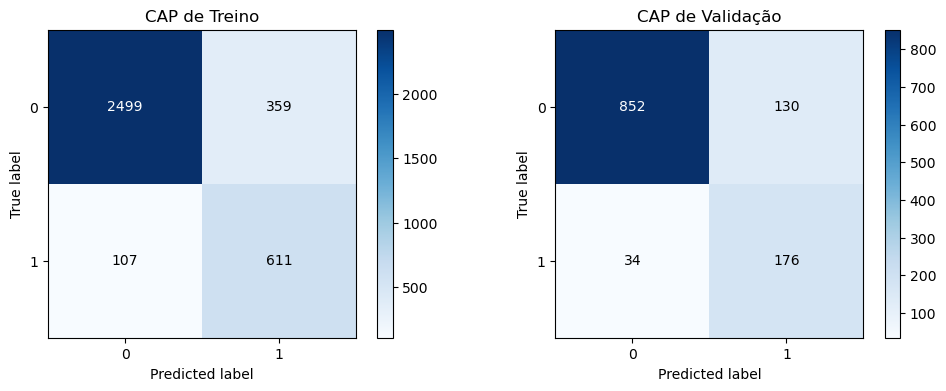

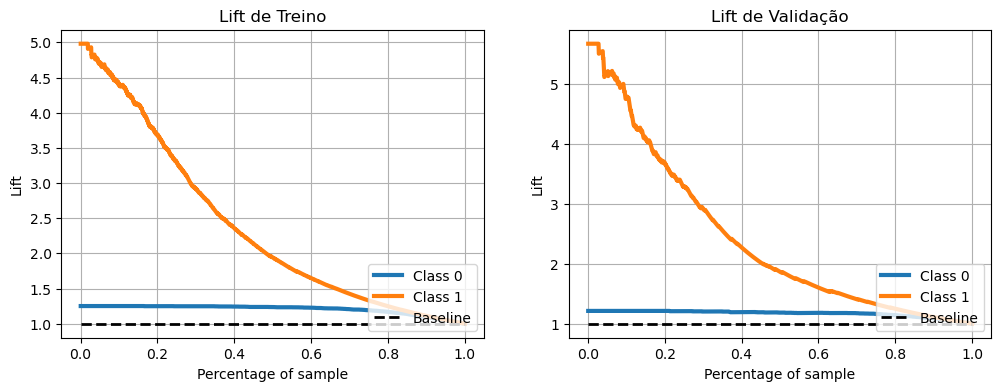

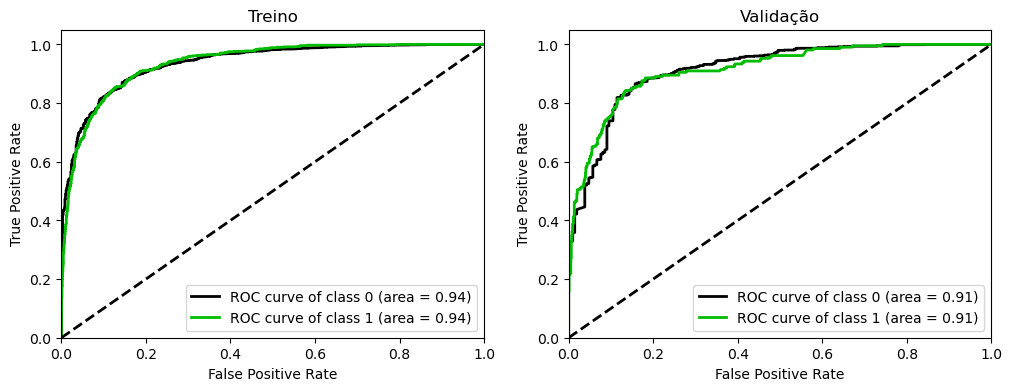

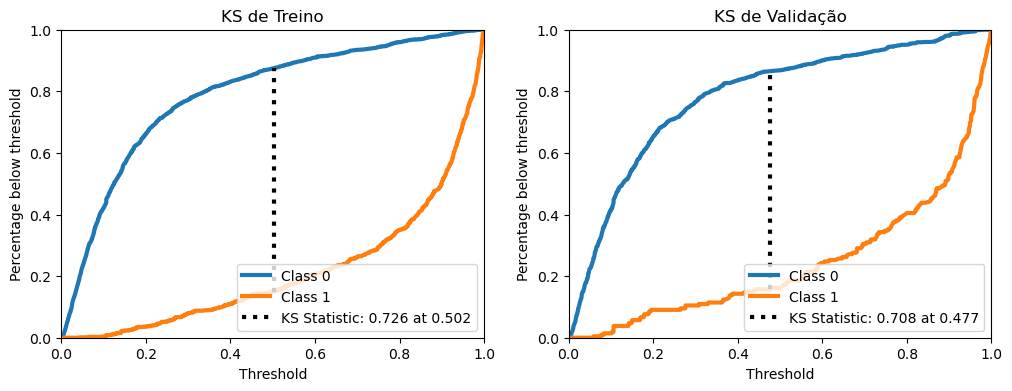

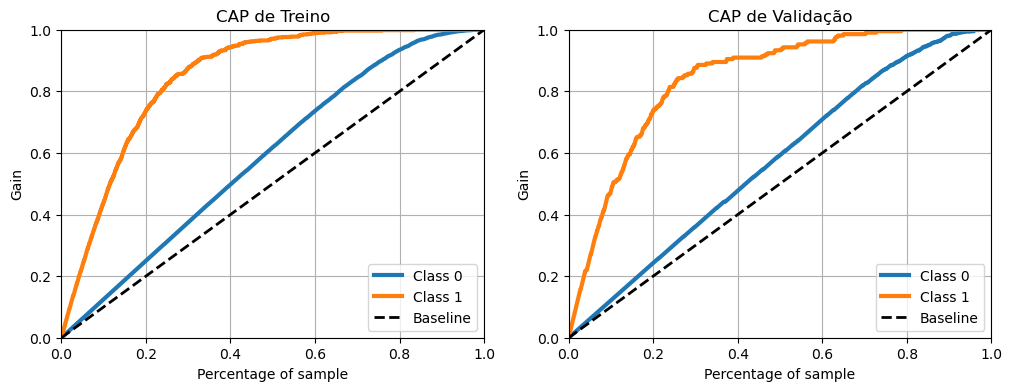

In [13]:
analyzer_3.display_confusion_matrix()
analyzer_3.display_lift()
analyzer_3.display_roc()
analyzer_3.display_ks()
analyzer_3.display_cumulative_gain()
plt.show()

In [126]:
display(analyzer_3.tab_dist_client_classe(train=False))

print('Distribuições de Clientes em Cada Classe de Risco')
display(analyzer_3.plot_estabilidade(train = False))

,SCR,Maus,Bons,B/M,Total
0,0,0.838983,0.161017,0.191919,1.0
1,1,0.482143,0.517857,1.074074,1.0
2,2,0.425532,0.574468,1.350000,1.0
3,3,0.361111,0.638889,1.769231,1.0
4,4,0.346939,0.653061,1.882353,1.0
5,5,0.111111,0.888889,8.000000,1.0
6,6,0.105263,0.894737,8.500000,1.0
7,7,0.026316,0.973684,37.000000,1.0
8,8,0.064000,0.936000,14.625000,1.0
9,9,0.007317,0.992683,135.666667,1.0


Distribuições de Clientes em Cada Classe de Risco


None

**Avaliando Impacto financeiro**

In [105]:
def criador_cenarios(y_predito_proba, corte):
    prob = ('prob_' + str(corte)).replace(".", "")

    df = pd.DataFrame({'y_predito_proba': y_predito_proba[:,1]})

    df['prob_01'] = (df['y_predito_proba'].between(0, 0.1)).astype(int)
    df['prob_02'] = (df['y_predito_proba'].between(0, 0.2)).astype(int)
    df['prob_03'] = (df['y_predito_proba'].between(0, 0.3)).astype(int)
    df['prob_04'] = (df['y_predito_proba'].between(0, 0.4)).astype(int)
    df['prob_05'] = (df['y_predito_proba'].between(0, 0.5)).astype(int)
    df['prob_06'] = (df['y_predito_proba'].between(0, 0.6)).astype(int)
    df['prob_07'] = (df['y_predito_proba'].between(0, 0.7)).astype(int)
    df['prob_08'] = (df['y_predito_proba'].between(0, 0.8)).astype(int)
    df['prob_09'] = (df['y_predito_proba'].between(0, 0.9)).astype(int)

    return df[prob]


In [101]:
def calculador_do_tomate(y_predito_proba, X, y, corte):
    
    predito = criador_cenarios(y_predito_proba = y_predito_proba, corte = corte)
    df_impact_fin = pd.DataFrame()

    df_impact_fin['LOAN'] = X['LOAN']
    df_impact_fin['REAL'] = y
    df_impact_fin['PREDICT'] = predito

    
    aprovei_bom_cliente = (df_impact_fin['PREDICT'] == 0) & (df_impact_fin['REAL'] == 0)

    # Quanto dinheiros deixamos de ganhar quando o modelo recusamos bons clientes
    reprovei_bom_cliente = (df_impact_fin['PREDICT'] == 1) & (df_impact_fin['REAL'] == 0) # Erro Tipo 1

    # Perda em dinheiros da operação com o modelo
    aprovei_mau_cliente = (df_impact_fin['PREDICT'] == 0) & (df_impact_fin['REAL'] == 1) # Erro Tipo 2

    reprovei_mau_cliente = (df_impact_fin['PREDICT'] == 1) & (df_impact_fin['REAL'] == 1)

    # Perda em dinheiros da operação sem o modelo
    bom_cliente = df_impact_fin[df_impact_fin['REAL'] == 0]['LOAN'].sum()
    mau_cliente = df_impact_fin[df_impact_fin['REAL'] == 1]['LOAN'].sum()

    credito_adiplente_com_modelo = df_impact_fin[aprovei_bom_cliente]['LOAN'].sum()
    acerto_tipo_1 = df_impact_fin[reprovei_mau_cliente]['LOAN'].sum()
    credito_inadinplente_com_modelo = df_impact_fin[aprovei_mau_cliente]['LOAN'].sum()
    custo_de_oportunidade = df_impact_fin[reprovei_bom_cliente]['LOAN'].sum()


    # Quanto percentualmente o modelo foi melhor que o processo anterior
    melhoria_pct_FN = (mau_cliente - credito_inadinplente_com_modelo) / mau_cliente

    # Todos os erros do modelo em dinheiros
    erro_total = credito_inadinplente_com_modelo + custo_de_oportunidade

    # Quanto percentualmente o modelo foi melhor que o processo anterior com Erro I e Erro II
    melhoria_pct_FN_FP = (mau_cliente - erro_total) / mau_cliente

    print(f'CORTE NA PROBABILIDADE {corte}')
    print(f'Melhoria de perdas considerando Apenas FN: $ {mau_cliente - credito_inadinplente_com_modelo:,.2f}')
    print(f'Melhoria % considerando FN: {(melhoria_pct_FN)*100:.2f}%')
    print(f'Melhoria de perdas considerando FP e FN: $ {erro_total:,.2f}')
    print(f'Melhoria % de perdas considerando FP e FN: {melhoria_pct_FN_FP * 100:,.2f}%')

In [103]:
y_predito_proba_test = analyzer_3.predito_proba(train=False)

X_test = pd.read_csv('/home/tomas/Documentos/gh-repos/Trabalho-APC-ASN/X_test.csv')

In [117]:
for _ in np.arange(0.1, 1.0, 0.1):
    print(round(_,2))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [122]:
calculador_do_tomate(y_predito_proba = y_predito_proba_test, 
                     X = X_test, 
                     y = y_test, 
                     corte = 0.5)

CORTE NA PROBABILIDADE 0.5
Melhoria de perdas considerando Apenas FN: $ 4,679,300.00
Melhoria % considerando FN: 98.55%
Melhoria de perdas considerando FP e FN: $ 911,500.00
Melhoria % de perdas considerando FP e FN: 80.80%


In [123]:
calculador_do_tomate(y_predito_proba = y_predito_proba_test, 
                     X = X_test, 
                     y = y_test, 
                     corte = 0.6)

CORTE NA PROBABILIDADE 0.6
Melhoria de perdas considerando Apenas FN: $ 4,684,300.00
Melhoria % considerando FN: 98.65%
Melhoria de perdas considerando FP e FN: $ 958,100.00
Melhoria % de perdas considerando FP e FN: 79.82%


In [124]:
calculador_do_tomate(y_predito_proba = y_predito_proba_test, 
                     X = X_test, 
                     y = y_test, 
                     corte = 0.7)

CORTE NA PROBABILIDADE 0.7
Melhoria de perdas considerando Apenas FN: $ 4,690,200.00
Melhoria % considerando FN: 98.78%
Melhoria de perdas considerando FP e FN: $ 999,900.00
Melhoria % de perdas considerando FP e FN: 78.94%


In [125]:
calculador_do_tomate(y_predito_proba = y_predito_proba_test, 
                     X = X_test, 
                     y = y_test, 
                     corte = 0.8)

CORTE NA PROBABILIDADE 0.8
Melhoria de perdas considerando Apenas FN: $ 4,693,400.00
Melhoria % considerando FN: 98.84%
Melhoria de perdas considerando FP e FN: $ 1,048,300.00
Melhoria % de perdas considerando FP e FN: 77.92%


### Relatório Assement

Em modelos de credit scoring duas coisas são muito importantes.
1. O modelo tem que fazer previsões acuradas;
2. O modelo precisa melhorar a cada aumento do cutoff

O ponto número 1 é muito simples de entender. A classificações de bom e mau (0 e 1) precisão ser acuradas. E a qualidade das classificações foram avaliadas com as métricas de qualidade de ajuste:

- Matriz de confusão;
- Lift;
- Curva ROC;
- Estatística KS;
- Gráfico de ganhos acumulativos;

Já o ponto 2 pode ser um pouco mais complexo.

A medida que cresce o escore, a porcentagem de maus dentro de cada classe deve ser cada vez menor.

Isso é importante principalmente por 3 razões:

1. Para diferentes grupos de scoring a instituição financeira pode praticar diferentes condições de crédito;
2. Caso o credor deseje reduzir a sua exposição ao risco, subir cut off será uma solução rápida;
3. Para um cenário que o modelo perca desempenho, subir o cut off também será uma solução rápida.

O ponto dois foi avaliado com a tabela "Distribuições de Clientes em Cada Classe de Risco" e com o gráfico da tabela logo abaixo.

A versão 3 do modelo foi a que melhor aprensentou uma redução constante da porcentagem de maus, a medida que o score crecia. Além disso os resultados das méticas de qualidade de ajuste foram semelhantes as outra duas versões do modelo, com uma leve redução de desempenho.